# Inside Unsupervised Learning: Generative Models and Recommender Systems
## Explore generative models and build movie recommender systems
### by Ankur A. Patel + O'Reilly Media, Inc.

## Overview
In this notebook, we will explore:
#1 The difference between discriminative and generative models
#2 Why generative models are so powerful
#3 The various types of generative models used today
#4 How to train a simple generative model (restricted Boltzmann machines)

Specifically, we will train RBMs to build a movie recommender system. After this course, you should be familiar with generative models and know a bit about how to train recommender systems in your field.

## Data Preparation
Load in the movie ratings dataset and prepare it.

We will use the MovieLens 20M Dataset. The original ratings file has 20,000,263 ratings, 27,278 movies, and 138,493 users.

We will use a reduced version of this data for this course. Our reduced version has data for the top 1,000 movies and a sample of 1,000 users.

Since not all 1,000 users rated all 1,000 movies, there are 664,550 ratings in total.

For each movie review, we have the original movieID, the original userID, the movie rating the user assigned, and the timestamp. We have two additional fields, the new movieID and the new userID, which are just reindexed versions of the original movieID and the original userID for the reduced dataset.

In [165]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [287]:
# Load the data
os.chdir('/home/jovyan/')
current_path = os.getcwd()
pickle_file = '/data/movielens_data/ratingReducedPickle'
ratingDF = pd.read_pickle(current_path + pickle_file)

In [288]:
# View 5 rows of the data
ratingDF.head()

,userId,movieId,rating,timestamp,newMovieId,newUserId
0,156,1,5.0,2002-11-19 20:54:26,1,1
1,156,2,5.0,2002-12-26 21:20:49,2,1
2,156,3,2.0,2002-12-02 03:53:45,3,1
3,156,5,3.0,2002-12-26 23:16:23,4,1
4,156,6,4.0,2002-11-20 19:55:17,5,1


In [289]:
# Calculate summary statistics on reduced dataset
n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users

print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  664550
Average number of ratings per user:  664.55


In [290]:
# Split into validation and test, such that each is 5% of the dataset
X_train, X_test = train_test_split(ratingDF, test_size=0.10, \
                                   shuffle=True, random_state=2018)

X_validation, X_test = train_test_split(X_test, test_size=0.50, \
                                        shuffle=True, random_state=2018)

In [291]:
# Confirm size of train, validation, and test datasets
print('Size of train set: ', len(X_train))
print('Size of validation set: ', len(X_validation))
print('Size of test set: ', len(X_test))

Size of train set:  598095
Size of validation set:  33227
Size of test set:  33228


In [292]:
# Generate ratings matrix for train
ratings_train = np.zeros((n_users, n_movies))
for row in X_train.itertuples():
    ratings_train[row[6]-1, row[5]-1] = row[3]

In [293]:
# Calculate sparsity of the train ratings matrix
sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 59.81%


In [294]:
# Generate ratings matrix for validation
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]

In [295]:
# Generate ratings matrix for test
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[3]

In [296]:
# Calculate sparsity of the validation ratings matrix
sparsity = float(len(ratings_validation.nonzero()[0]))
sparsity /= (ratings_validation.shape[0] * ratings_validation.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 3.32%


## Experiment #1 - Naive Recommender System A
Assign naive 3.5 rating to each missing movie review and calculate the mean squared error.

In [297]:
# Store actual ratings for the validation set
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

# Assign "naive" 3.5 rating to missing values in the validation set
pred_validation = np.zeros((len(X_validation),1))
pred_validation[pred_validation==0] = 3.5

# Calculate mean square error using this naive prediction
naive_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using naive prediction:', naive_prediction)

Mean squared error using naive prediction: 1.0269660216089325


## Experiment #2 - Naive Recommender System B
Predict a user's rating based on user's average rating for all other movies the user has rated.

In [298]:
# Average user rating recommender system
ratings_validation_prediction = np.zeros((n_users, n_movies))
i = 0
for row in ratings_train:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] \
        = np.mean(row[row>0])
    i += 1

pred_validation = ratings_validation_prediction \
    [ratings_validation.nonzero()].flatten()
user_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using user average:', user_average)

Mean squared error using user average: 0.8588526417952581


## Experiment #3 - Naive Recommender System C
Predict a user's rating for a movie based on the average rating other users have given that movie.

In [299]:
# Average movie rating recommender system
ratings_validation_prediction = np.zeros((n_users, n_movies)).T
i = 0
for row in ratings_train.T:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] \
        = np.mean(row[row>0])
    i += 1

ratings_validation_prediction = ratings_validation_prediction.T
pred_validation = ratings_validation_prediction \
    [ratings_validation.nonzero()].flatten()
movie_average = mean_squared_error(pred_validation.astype(np.float64), \
                                   actual_validation.astype(np.float64))
print('Mean squared error using movie average:', movie_average)

Mean squared error using movie average: 0.7891457799396219


## Experiment #4 - Recommender System using Matrix Factorization
We will use 1 latent factor, but you could experiment with a different number of latent factors.

In [22]:
n_latent_factors = 1

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, \
                           output_dim=n_latent_factors, \
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, \
                            output_dim=n_latent_factors,
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [23]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], \
                    y=X_train.rating, epochs=10, \
                    validation_data=([X_validation.newUserId, \
                    X_validation.newMovieId], X_validation.rating), \
                    verbose=1)

Train on 598095 samples, validate on 33227 samples
Epoch 1/10
598095/598095 [==============================] - 41s 69us/step - loss: 4.0571 - val_loss: 0.6451
Epoch 2/10
598095/598095 [==============================] - 43s 72us/step - loss: 0.6437 - val_loss: 0.6429
Epoch 3/10
598095/598095 [==============================] - 44s 73us/step - loss: 0.6435 - val_loss: 0.6415
Epoch 4/10
598095/598095 [==============================] - 45s 75us/step - loss: 0.6435 - val_loss: 0.6423
Epoch 5/10
598095/598095 [==============================] - 44s 73us/step - loss: 0.6434 - val_loss: 0.6423
Epoch 6/10
598095/598095 [==============================] - 44s 73us/step - loss: 0.6434 - val_loss: 0.6432
Epoch 7/10
598095/598095 [==============================] - 44s 73us/step - loss: 0.6434 - val_loss: 0.6438
Epoch 8/10
598095/598095 [==============================] - 44s 73us/step - loss: 0.6436 - val_loss: 0.6437
Epoch 9/10
598095/598095 [==============================] - 44s 73us/step - loss: 0.6

Minimum MSE:  0.6415040424055428


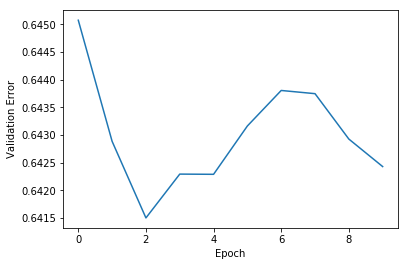

In [24]:
pd.Series(history.history['val_loss'][:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

preds = model.predict(x=[X_validation.newUserId, X_validation.newMovieId])

In [25]:
# MSE on train
preds = model.predict(x=[X_train.newUserId, X_train.newMovieId])
mean_squared_error(preds, X_train.rating)

0.639604148555906

In [26]:
# MSE on validation
preds = model.predict(x=[X_validation.newUserId, X_validation.newMovieId])
mean_squared_error(preds, X_validation.rating)

0.642431686033174

In [27]:
# MSE on test
preds = model.predict(x=[X_test.newUserId, X_test.newMovieId])
mean_squared_error(preds, X_test.rating)

0.6315331049869991

## Experiment #5 - Recommender System using RBMs

In [441]:
# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), \
                        self.batchsize),range(self.batchsize,len(X), \
                                              self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, \
                                _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        visibleGen = tf.nn.sigmoid(tf.matmul(out, tf.transpose(_w)) + _vb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(out)
            sess.run(visibleGen)
            return sess.run(out), sess.run(visibleGen)

In [442]:
# Begin the training cycle

# Convert inputX into float32
inputX = ratings_train/5.0
inputX = inputX.astype(np.float32)

# Define the parameters of the RBMs we will train
rbm=RBM(1000,10,0.1,300,200)

In [443]:
# Train RBM model
err = rbm.train(inputX)
outputX, reconstructedX = rbm.rbm_output(inputX)

Epoch: 0 reconstruction error: 0.373344
Epoch: 1 reconstruction error: 0.356891
Epoch: 2 reconstruction error: 0.351545
Epoch: 3 reconstruction error: 0.354577
Epoch: 4 reconstruction error: 0.348203
Epoch: 5 reconstruction error: 0.350643
Epoch: 6 reconstruction error: 0.349395
Epoch: 7 reconstruction error: 0.349601
Epoch: 8 reconstruction error: 0.349216
Epoch: 9 reconstruction error: 0.346847
Epoch: 10 reconstruction error: 0.345416
Epoch: 11 reconstruction error: 0.344123
Epoch: 12 reconstruction error: 0.343218
Epoch: 13 reconstruction error: 0.342587
Epoch: 14 reconstruction error: 0.341027
Epoch: 15 reconstruction error: 0.340032
Epoch: 16 reconstruction error: 0.340589
Epoch: 17 reconstruction error: 0.342816
Epoch: 18 reconstruction error: 0.340215
Epoch: 19 reconstruction error: 0.339538
Epoch: 20 reconstruction error: 0.339979
Epoch: 21 reconstruction error: 0.339494
Epoch: 22 reconstruction error: 0.339618
Epoch: 23 reconstruction error: 0.338508
Epoch: 24 reconstruction e

Epoch: 198 reconstruction error: 0.314487
Epoch: 199 reconstruction error: 0.313704
Epoch: 200 reconstruction error: 0.313605
Epoch: 201 reconstruction error: 0.313391
Epoch: 202 reconstruction error: 0.313578
Epoch: 203 reconstruction error: 0.314003
Epoch: 204 reconstruction error: 0.313812
Epoch: 205 reconstruction error: 0.313796
Epoch: 206 reconstruction error: 0.313847
Epoch: 207 reconstruction error: 0.313798
Epoch: 208 reconstruction error: 0.313366
Epoch: 209 reconstruction error: 0.313118
Epoch: 210 reconstruction error: 0.313262
Epoch: 211 reconstruction error: 0.313039
Epoch: 212 reconstruction error: 0.313467
Epoch: 213 reconstruction error: 0.313410
Epoch: 214 reconstruction error: 0.313590
Epoch: 215 reconstruction error: 0.313136
Epoch: 216 reconstruction error: 0.313008
Epoch: 217 reconstruction error: 0.312980
Epoch: 218 reconstruction error: 0.313654
Epoch: 219 reconstruction error: 0.312918
Epoch: 220 reconstruction error: 0.313168
Epoch: 221 reconstruction error: 0

Text(0,0.5,'Reconstruction Error')

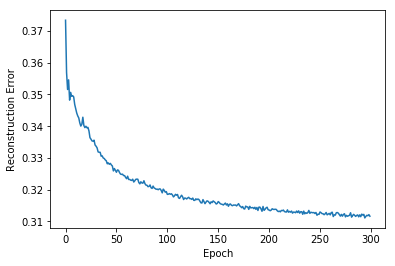

In [452]:
# Plot reconstruction errors
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")

In [453]:
# Find scaling factor based on training set
actual_train = ratings_train[ratings_train.nonzero()].flatten()
train_mean = np.mean(actual_train)

In [454]:
# Calculate MSE on train set
predictionsArray = reconstructedX
pred_train = \
    predictionsArray[ratings_train.nonzero()].flatten()
pred_train = pred_train * train_mean/np.mean(pred_train)
actual_train = \
    ratings_train[ratings_train.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_train, actual_train)
print('Mean squared error using RBM prediction:', rbm_prediction)

Mean squared error using RBM prediction: 1.4462461142751912


In [455]:
# Calculate MSE on validation set
predictionsArray = reconstructedX
pred_validation = \
    predictionsArray[ratings_validation.nonzero()].flatten()
pred_validation = pred_validation * train_mean/np.mean(pred_validation)
actual_validation = \
    ratings_validation[ratings_validation.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using RBM prediction:', rbm_prediction)

Mean squared error using RBM prediction: 1.5199086884585058


In [450]:
# View generated predictions on validation set
pred_validation

array([2.3059192, 4.7426066, 1.3889569, ..., 4.119414 , 1.9129831,
       2.7060237], dtype=float32)

In [449]:
# View actual ratings in validation set
actual_validation

array([4. , 4. , 3. , ..., 3.5, 3. , 4.5])

## Exercise
Train the RBM with an input layer of 1,000 nodes, a output layer of 50 nodes, a learning rate of 0.3, and a batch size of 32 for 100 epochs.

Then, evaluate the performance on the train set and validation set.

In [ ]:
# Begin the training cycle

# Convert inputX into float32
inputX = ratings_train/5.0
inputX = inputX.astype(np.float32)

# Define the parameters of the RBMs we will train
rbm=RBM(#input nodes, #output nodes, #learning rate, #epochs, #batch size)

In [ ]:
# Train RBM model
err = rbm.train(#Fill in)
outputX, reconstructedX = rbm.rbm_output(#Fill in)

In [ ]:
# Plot reconstruction errors
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")

In [ ]:
# Calculate MSE on train set
predictionsArray = reconstructedX
pred_train = \
    predictionsArray[ratings_train.nonzero()].flatten()
pred_train = pred_train * train_mean/np.mean(pred_train)
actual_train = \
    ratings_train[ratings_train.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_train, actual_train)
print('Mean squared error using RBM prediction:', rbm_prediction)

In [ ]:
# Calculate MSE on validation set
predictionsArray = reconstructedX
pred_validation = \
    predictionsArray[ratings_validation.nonzero()].flatten()
pred_validation = pred_validation * train_mean/np.mean(pred_validation)
actual_validation = \
    ratings_validation[ratings_validation.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using RBM prediction:', rbm_prediction)

## Answers to Exercise

In [466]:
# Begin the training cycle

# Convert inputX into float32
inputX = ratings_train/5.0
inputX = inputX.astype(np.float32)

# Define the parameters of the RBMs we will train
rbm=RBM(1000, 50, 0.3, 100, 32)

In [467]:
# Train RBM model
err = rbm.train(inputX)
outputX, reconstructedX = rbm.rbm_output(inputX)

Epoch: 0 reconstruction error: 0.340329
Epoch: 1 reconstruction error: 0.327993
Epoch: 2 reconstruction error: 0.324682
Epoch: 3 reconstruction error: 0.319737
Epoch: 4 reconstruction error: 0.318710
Epoch: 5 reconstruction error: 0.318334
Epoch: 6 reconstruction error: 0.317085
Epoch: 7 reconstruction error: 0.314701
Epoch: 8 reconstruction error: 0.311883
Epoch: 9 reconstruction error: 0.311666
Epoch: 10 reconstruction error: 0.312351
Epoch: 11 reconstruction error: 0.310968
Epoch: 12 reconstruction error: 0.309597
Epoch: 13 reconstruction error: 0.309275
Epoch: 14 reconstruction error: 0.307854
Epoch: 15 reconstruction error: 0.306642
Epoch: 16 reconstruction error: 0.306803
Epoch: 17 reconstruction error: 0.306945
Epoch: 18 reconstruction error: 0.305921
Epoch: 19 reconstruction error: 0.305663
Epoch: 20 reconstruction error: 0.305268
Epoch: 21 reconstruction error: 0.305762
Epoch: 22 reconstruction error: 0.307384
Epoch: 23 reconstruction error: 0.305124
Epoch: 24 reconstruction e

Text(0,0.5,'Reconstruction Error')

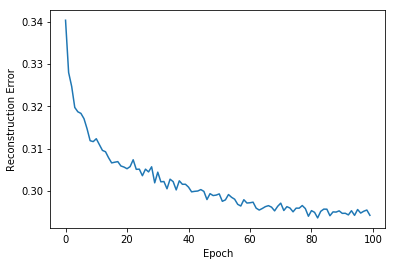

In [470]:
# Plot reconstruction errors
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")

In [468]:
# Calculate MSE on train set
predictionsArray = reconstructedX
pred_train = \
    predictionsArray[ratings_train.nonzero()].flatten()
pred_train = pred_train * train_mean/np.mean(pred_train)
actual_train = \
    ratings_train[ratings_train.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_train, actual_train)
print('Mean squared error using RBM prediction:', rbm_prediction)

Mean squared error using RBM prediction: 1.507355846739135


In [469]:
# Calculate MSE on validation set
predictionsArray = reconstructedX
pred_validation = \
    predictionsArray[ratings_validation.nonzero()].flatten()
pred_validation = pred_validation * train_mean/np.mean(pred_validation)
actual_validation = \
    ratings_validation[ratings_validation.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using RBM prediction:', rbm_prediction)

Mean squared error using RBM prediction: 1.6891776448466562


## Conclusion
In this notebook, we explored generative models and RBMs.

We then built non-generative movie recommender systems.

And then we built a generative model-based movie recommender system using RBMs.

The generative model-based movie recommender system did not fare as well as the non-generative movie recommender systems.

But, there is a lot of room for improvement. This is what makes building great generative models and recommender systems difficult.

Congratulations, you've finished this course! 
Go build more recommender systems in your field!

The next course in the Inside Unsupervised Learning series is Anomaly Detection Using Unsupervised Learning.
https://learning.oreilly.com/live-training/courses/inside-unsupervised-learning-anomaly-detection-using-dimensionality-reduction/0636920289654/

You could also learn more about Unsupervised Learning in my book, Hands-on Unsupervised Learning Using Python.
https://www.unsupervisedlearningbook.com/

Finally, there is a Slack commmunity for you to join.
https://join.slack.com/t/unsupervisedbook/shared_invite/enQtNjQzMjMyMjAyMjQyLTE3MWZlNTU0N2U3Zjg2MzNjMjM5MTI4YmIxY2ExOTIzNzA0ZTVmYjAyYWJhMjE1ZTc3NDRiNDIwOGM5YmY0M2E